<a href="https://colab.research.google.com/github/Ashutosh-krs/fastbook/blob/master/Untitle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 194kB 11.3MB/s 
     |████████████████████████████████| 1.2MB 28.4MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key=os.environ.get('AZURE_SEARCH_KEY','c6ad9405ec9d4e05a11a0bb40b7b1d6f')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [5]:
results=search_images_bing(key,'krsna')
ims=results.attrgot('contentUrl')
len(ims)

150

In [6]:
from google.colab import drive
drive.mount('/content/drive')

my_path = "/Colab Notebooks" # Your path
gdrive_path = "/content/drive" + "/MyDrive" + my_path

Mounted at /content/drive


In [7]:
dest='/content/drive/MyDrive/Colab Notebooks/krsna.jpg'
download_url(ims[1],dest)

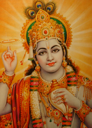

In [8]:
im=Image.open(dest)
im.to_thumb(128, 128)

In [9]:
god_types='krsna','vishnu','ram'
path=Path('gods')

In [10]:
if not path.exists():
  path.mkdir()
  for o in god_types:
    dest=(path/o)
    dest.mkdir(exist_ok=True)
    results=search_images_bing(key,f'{o} gods')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns=get_image_files(path)
fns

(#439) [Path('gods/krsna/00000034.jpg'),Path('gods/krsna/00000015.jpg'),Path('gods/krsna/00000002.jpg'),Path('gods/krsna/00000095.jpg'),Path('gods/krsna/00000025.jpg'),Path('gods/krsna/00000096.jpg'),Path('gods/krsna/00000019.jpg'),Path('gods/krsna/00000044.jpg'),Path('gods/krsna/00000023.jpg'),Path('gods/krsna/00000033.png')...]

In [12]:
failed=verify_images(fns)
failed

(#4) [Path('gods/ram/00000112.jpg'),Path('gods/vishnu/00000147.jpg'),Path('gods/vishnu/00000088.jpg'),Path('gods/vishnu/00000038.jpg')]

In [13]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

In [14]:
gods = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = gods.dataloaders(path)

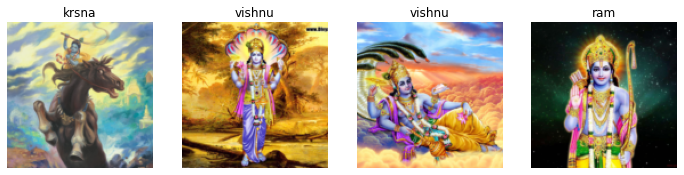

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

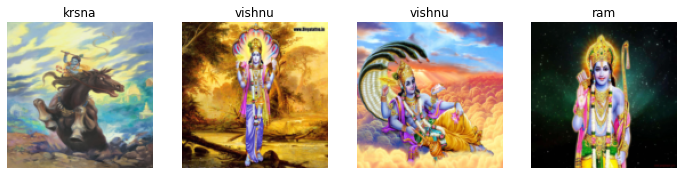

In [17]:
gods = gods.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = gods.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

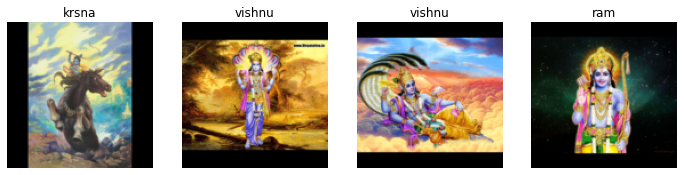

In [18]:
gods = gods.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = gods.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

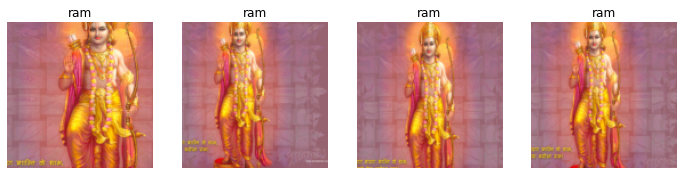

In [19]:
gods = gods.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = gods.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

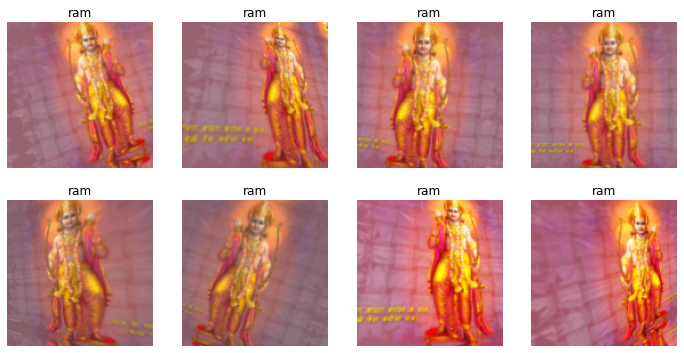

In [20]:
gods = gods.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = gods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
gods = gods.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = gods.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.543740,1.309760,0.471264,01:14


epoch,train_loss,valid_loss,error_rate,time
0,1.094939,0.843011,0.379310,01:51
1,0.933389,0.700816,0.310345,01:40
2,0.814460,0.677461,0.241379,01:38
3,0.717593,0.660593,0.229885,01:40


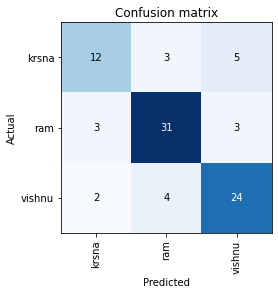

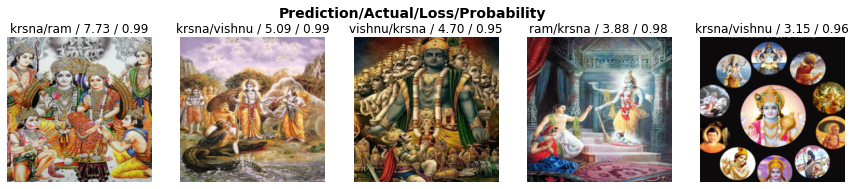

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

interp.plot_top_losses(5, nrows=1)

In [24]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('/content/drive/MyDrive/Colab Notebooks/krsna.jpg')

('krsna', tensor(0), tensor([0.5310, 0.1335, 0.3355]))

In [30]:
learn_inf.dls.vocab

['krsna', 'ram', 'vishnu']

In [31]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['/content/drive/MyDrive/Colab Notebooks/krsna.jpg'])

In [33]:
img = PILImage.create(btn_upload.data[-1])

In [34]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)

In [36]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: krsna; Probability: 0.5310')

In [37]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [40]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [41]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.9MB 7.4MB/s 
     |████████████████████████████████| 112kB 40.1MB/s 
     |████████████████████████████████| 552kB 51.2MB/s 
     |████████████████████████████████| 194kB 35.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=25dae85dd611ea7e411c9d37fb7586508806f3f4828e239d371d603d8496e4ed
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
ERROR: nbdev 1.1.12 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.3.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found exis

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
